<a href="https://colab.research.google.com/github/shrutiroy03/hitori-rl/blob/main/hitori.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
import random
from collections import deque
from typing import List, Tuple

import numpy as np

import torch
import torch.nn as nn
import torch.optim as optim
import random
import matplotlib.pyplot as plt

In [ ]:
GameState = {
    "LOST": -1,
    "IN_PROGRESS": 0,
    "WON": 1,
}

def check_rule1(board: List[List[int]]) -> bool:
    size = len(board)
    for i in range(size):
        row_seen = set()
        col_seen = set()
        for j in range(size):
            row_val = board[i][j]
            col_val = board[j][i]
            if row_val != 0:
                if row_val in row_seen:
                    return False
                row_seen.add(row_val)
            if col_val != 0:
                if col_val in col_seen:
                    return False
                col_seen.add(col_val)
    return True

def check_rule2(mask: List[List[bool]]) -> bool:
    size = len(mask)
    for x in range(size):
        for y in range(size):
            if mask[x][y]:
                for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < size and 0 <= ny < size:
                        if mask[nx][ny]:
                            return False
    return True

def check_rule3(board: List[List[int]]) -> bool:
    size = len(board)
    visited = [[False] * size for _ in range(size)]

    for x in range(size):
        for y in range(size):
            if board[x][y] != 0:
                start = (x, y)
                break
        else:
            continue
        break
    else:
        return False

    queue = deque([start])
    visited[start[0]][start[1]] = True

    while queue:
        x, y = queue.popleft()
        for dx, dy in [(-1, 0), (1, 0), (0, -1), (0, 1)]:
            nx, ny = x + dx, y + dy
            if 0 <= nx < size and 0 <= ny < size:
                if not visited[nx][ny] and board[nx][ny] != 0:
                    visited[nx][ny] = True
                    queue.append((nx, ny))

    for x in range(size):
        for y in range(size):
            if board[x][y] != 0 and not visited[x][y]:
                return False
    return True

class HitoriGame:
    def __init__(self, board_size: int, seed: int = None):
        self.board_size = board_size
        self.seed = seed or random.randint(0, 9999999)
        random.seed(self.seed)

        self.solution_board = [[0] * board_size for _ in range(board_size)]
        self.solution_painted_mask = [[False] * board_size for _ in range(board_size)]
        self.player_painted_mask = [[False] * board_size for _ in range(board_size)]
        self.state = [[0] * board_size for _ in range(board_size)]

        self._generate_solution_board()
        self._initialize_player_board()
        self.status = GameState["IN_PROGRESS"]


    def _generate_solution_board(self):
        while True:
            # Step 1: initialize masks
            board = [[0] * self.board_size for _ in range(self.board_size)]
            painted = [[False] * self.board_size for _ in range(self.board_size)]

            # Step 2: randomly select non-adjacent painted cells
            num_painted = random.randint(13, 18) if self.board_size == 8 else max(1, self.board_size)
            attempts = 0
            while num_painted > 0 and attempts < 500:
                x = random.randint(0, self.board_size - 1)
                y = random.randint(0, self.board_size - 1)

                if painted[x][y]: continue
                # Check neighbors
                adjacent = False
                for dx, dy in [(-1,0), (1,0), (0,-1), (0,1)]:
                    nx, ny = x + dx, y + dy
                    if 0 <= nx < self.board_size and 0 <= ny < self.board_size:
                        if painted[nx][ny]:
                            adjacent = True
                            break
                if adjacent:
                    attempts += 1
                    continue

                painted[x][y] = True
                num_painted -= 1

            # Step 3: Create accumulators
            horiz_accum = [[False] * (self.board_size + 2) for _ in range(self.board_size)]
            vert_accum = [False] * (self.board_size + 2)

            success = True
            for x in range(self.board_size):
                vert_accum = [False] * (self.board_size + 2)
                total_choices = self.board_size + 1
                for y in range(self.board_size):
                    if painted[x][y]:
                        continue
                    attempts = 0
                    while attempts < 1000:
                        i = random.randint(1, self.board_size)
                        if not vert_accum[i] and not horiz_accum[y][i]:
                            board[x][y] = i
                            vert_accum[i] = True
                            horiz_accum[y][i] = True
                            break
                        attempts += 1
                    else:
                        success = False
                        break
                if not success:
                    break
            if not success:
                continue

            # Step 4: Fill painted cells with duplicates
            for x in range(self.board_size):
                for y in range(self.board_size):
                    if painted[x][y]:
                        candidates = [board[x][j] for j in range(self.board_size) if not painted[x][j] and board[x][j] != 0]
                        candidates += [board[i][y] for i in range(self.board_size) if not painted[i][y] and board[i][y] != 0]
                        if not candidates:
                            success = False
                            break
                        board[x][y] = random.choice(candidates)
                if not success:
                    break
            if not success:
                continue

            # Step 5: Build visible board
            visible = [[0 if painted[x][y] else board[x][y] for y in range(self.board_size)] for x in range(self.board_size)]
            if check_rule2(painted) and check_rule3(visible):
                # Finalize
                self.solution_board = board
                self.solution_painted_mask = painted
                return


    def _initialize_player_board(self):
        for x in range(self.board_size):
            for y in range(self.board_size):
                self.state[x][y] = self.solution_board[x][y]

    def print_solution_with_paint(self):
        print("Full Solution (with painted cells shown as X):")
        for y in range(self.board_size):
            row = []
            for x in range(self.board_size):
                if self.solution_painted_mask[x][y]:
                    row.append("X")
                else:
                    row.append(str(self.solution_board[x][y]))
            print(" ".join(row))
        print()

        solution_visible_board = [[
            0 if self.solution_painted_mask[x][y] else self.solution_board[x][y]
            for y in range(self.board_size)
        ] for x in range(self.board_size)]

        print("Checking solution board rules:")
        print(f"Rule 1 (no duplicates): {check_rule1(solution_visible_board)}")
        print(f"Rule 2 (no adjacent painted): {check_rule2(self.solution_painted_mask)}")
        print(f"Rule 3 (connected unpainted): {check_rule3(solution_visible_board)}\n")

    def print_state(self):
        print("Current Game Board:")
        for y in range(self.board_size):
            row = []
            for x in range(self.board_size):
                row.append("X" if self.player_painted_mask[x][y] else str(self.state[x][y]))
            print(" ".join(row))
        print(f"Status: {self.status}  (−1 = lost, 0 = in progress, 1 = won)\n")

    def check_loss(self) -> Tuple[bool, List[int]]:
        """
        Check if player violates Rule 2 or Rule 3.
        Returns (True, [rule_numbers]) if any violated.
        """
        broken = []
        if not check_rule2(self.player_painted_mask):
            broken.append(2)
        if not check_rule3(self.state):
            broken.append(3)
        return (len(broken) > 0, broken)


    def check_win(self) -> bool:
        """Return True if the player satisfies all 3 rules."""
        return (
            check_rule1(self.state)
            and check_rule2(self.player_painted_mask)
            and check_rule3(self.state)
        )

    def is_valid_move(self, x: int, y: int) -> bool:
        return not self.player_painted_mask[x][y]

    def get_valid_actions(self) -> List[int]:
        valid_actions = []
        for x in range(self.board_size):
            for y in range(self.board_size):
                if not self.player_painted_mask[x][y]:
                    valid_actions.append(x * self.board_size + y)
        return valid_actions


    def move(self, x: int, y: int) -> Tuple[List[List[int]], int]:
        if self.status != GameState["IN_PROGRESS"]:
            # print("Game is already over.")
            return self.state, self.status

        if self.player_painted_mask[x][y]:
            # print("Cell already painted.")
            return self.state, self.status

        self.state[x][y] = 0
        self.player_painted_mask[x][y] = True

        lost, broken_rules = self.check_loss()
        if lost:
            self.status = GameState["LOST"]
            # print(f"You broke Rule(s): {', '.join(map(str, broken_rules))}")
        elif self.check_win():
            self.status = GameState["WON"]

        return self.state, self.status

    def run(self):
        self.print_solution_with_paint()

        self.print_state()


        while self.status == GameState["IN_PROGRESS"]:
            try:
                x, y = map(int, input("Enter coordinates to paint (x y, 0-indexed): ").split())
                self.move(x, y)
                self.print_state()
            except Exception as e:
                print("Invalid input:", e)

        if self.status == GameState["WON"]:
            print("You won!")
        elif self.status == GameState["LOST"]:
            print("You lost!")


# Main
'''
if __name__ == "__main__":
    size = 4 #int(input("Enter board size (e.g., 4, 5, 6): "))
    game = HitoriGame(board_size=size)
    game.run()
'''

'\nif __name__ == "__main__":\n    size = 4 #int(input("Enter board size (e.g., 4, 5, 6): "))\n    game = HitoriGame(board_size=size)\n    game.run()\n'

In [ ]:
# hitori_rl_env.py

class HitoriEnv:
    def __init__(self, board_size=4):
        self.board_size = board_size
        self.game = HitoriGame(board_size=board_size)
        self.action_space = board_size * board_size

    def reset(self):
        self.game = HitoriGame(board_size=self.board_size)
        return self._get_state()

    def step(self, action):
        x, y = divmod(action, self.board_size)

        if not self.game.is_valid_move(x, y):
            # Penalize for invalid move
            next_state = self._get_state()
            return next_state, -5.0, False, {"invalid": True}

        self.game.move(x, y)
        next_state = self._get_state()

        done = self.game.status != 0

        if self.game.status == -1:
            reward = -10  # Penalty for losing
        elif self.game.status == 1:
            reward = 100  # Reward for winning
        else:
            reward = -1  # Small penalty for each move

        return next_state, reward, done, {}

    def render(self):
        self.game.print_state()

    def get_valid_actions(self) -> List[int]:
        return self.game.get_valid_actions()

    def _get_state(self):
        # Flattened visible state: 0 for painted, number otherwise
        return np.array([[0 if self.game.player_painted_mask[i][j] else self.game.state[i][j]
                          for j in range(self.board_size)] for i in range(self.board_size)], dtype=np.float32)


In [ ]:
class QNetwork(nn.Module):
    def __init__(self, input_dim, output_dim):
        super().__init__()
        self.model = nn.Sequential(
            nn.Flatten(),
            nn.Linear(input_dim, 128),
            nn.ReLU(),
            nn.Linear(128, 128),
            nn.ReLU(),
            nn.Linear(128, output_dim)
        )

    def forward(self, x):
        return self.model(x)

# ---- Action Selection with Masking ----
def select_action(state, valid_actions, epsilon, policy_net, device):
    if random.random() < epsilon:
        return random.choice(valid_actions)
    else:
        state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
        q_values = policy_net(state_tensor).detach().cpu().numpy()[0]

        masked_q_values = np.full_like(q_values, -np.inf)
        for a in valid_actions:
            masked_q_values[a] = q_values[a]

        return int(np.argmax(masked_q_values))

class ReplayBuffer:
    def __init__(self, capacity=10000):
        self.buffer = deque(maxlen=capacity)

    def push(self, transition):
        self.buffer.append(transition)

    def sample(self, batch_size):
        batch = random.sample(self.buffer, batch_size)
        return zip(*batch)

    def __len__(self):
        return len(self.buffer)

def train_dqn(board_size=4, episodes=10000, batch_size=64, gamma=0.99, lr=1e-3,
              epsilon_start=1.0, epsilon_min=0.05, epsilon_decay=0.999, valid_mask = False):
    env = HitoriEnv(board_size)
    state_size = board_size * board_size
    action_size = state_size

    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    q_net = QNetwork(state_size, action_size).to(device)
    target_net = QNetwork(state_size, action_size).to(device)
    target_net.load_state_dict(q_net.state_dict())
    target_net.eval()

    optimizer = optim.Adam(q_net.parameters(), lr=lr)
    buffer = ReplayBuffer()

    epsilon = epsilon_start
    steps_done = 0
    all_rewards = []

    for episode in range(episodes):
        state = env.reset()
        done = False
        total_reward = 0

        while not done:
            if valid_mask:
                valid_actions = env.get_valid_actions()
                action = select_action(state, valid_actions, epsilon, q_net, device)
            else:
                state_tensor = torch.FloatTensor(state).unsqueeze(0).to(device)
                q_values = q_net(state_tensor).detach().cpu().numpy()[0]
                action = int(np.argmax(q_values))

            next_state, reward, done, _ = env.step(action)
            buffer.push((state, action, reward, next_state, done))
            state = next_state
            total_reward += reward
            steps_done += 1

            if len(buffer) >= batch_size:
                states, actions, rewards, next_states, dones = buffer.sample(batch_size)
                states = torch.tensor(np.array(states), dtype=torch.float32).to(device)
                actions = torch.tensor(actions, dtype=torch.int64).unsqueeze(1).to(device)
                rewards = torch.tensor(rewards, dtype=torch.float32).unsqueeze(1).to(device)
                next_states = torch.tensor(np.array(next_states), dtype=torch.float32).to(device)
                dones = torch.tensor(dones, dtype=torch.bool).unsqueeze(1).to(device)

                q_values = q_net(states).gather(1, actions)
                next_q_values = target_net(next_states).max(1)[0].detach().unsqueeze(1)
                targets = rewards + gamma * next_q_values * (~dones)

                loss = nn.MSELoss()(q_values, targets)

                optimizer.zero_grad()
                loss.backward()
                optimizer.step()

        if episode % 10 == 0:
            target_net.load_state_dict(q_net.state_dict())

        if (episode+1) % 100 == 0:
            print(f"Episode {episode+1}, Reward: {total_reward}, Epsilon: {epsilon:.3f}")

        epsilon = max(epsilon * epsilon_decay, epsilon_min)
        all_rewards.append(total_reward)

    torch.save(q_net.state_dict(), "dqn_hitori_model.pt")
    return all_rewards

In [ ]:
rewards = train_dqn()

Episode 100, Reward: -10.2, Epsilon: 0.906
Episode 200, Reward: -10.2, Epsilon: 0.819
Episode 300, Reward: -10.1, Epsilon: 0.741
Episode 400, Reward: -10.4, Epsilon: 0.671
Episode 500, Reward: -10.2, Epsilon: 0.607
Episode 600, Reward: -10.2, Epsilon: 0.549
Episode 700, Reward: -10.1, Epsilon: 0.497
Episode 800, Reward: -10.3, Epsilon: 0.450
Episode 900, Reward: -10.4, Epsilon: 0.407
Episode 1000, Reward: -10.2, Epsilon: 0.368
Episode 1100, Reward: -10.4, Epsilon: 0.333
Episode 1200, Reward: -10.2, Epsilon: 0.301
Episode 1300, Reward: -10.3, Epsilon: 0.273
Episode 1400, Reward: -10.5, Epsilon: 0.247
Episode 1500, Reward: -10.5, Epsilon: 0.223
Episode 1600, Reward: -10.3, Epsilon: 0.202
Episode 1700, Reward: -10.5, Epsilon: 0.183
Episode 1800, Reward: -10.5, Epsilon: 0.165
Episode 1900, Reward: -10.5, Epsilon: 0.150
Episode 2000, Reward: -10.5, Epsilon: 0.135
Episode 2100, Reward: -10.5, Epsilon: 0.122
Episode 2200, Reward: -10.5, Epsilon: 0.111
Episode 2300, Reward: -10.5, Epsilon: 0.1

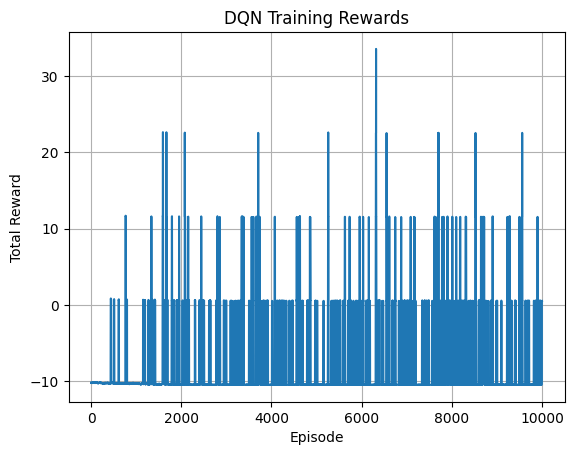

In [ ]:
cumulative_sum = np.cumsum(rewards)
running_avg = (cumulative_sum[10:] - cumulative_sum[:-10]) / 10

initial_values = [np.mean(rewards[:i+1]) for i in range(10-1)]
running_avg = np.concatenate((initial_values, running_avg))

# Plotting rewards
plt.plot(running_avg)
plt.xlabel("Episode")
plt.ylabel("Total Reward")
plt.title("DQN Training Rewards")
plt.grid(True)
plt.show()